In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from math import pi
from scipy.special import gammaln
import scipy as sc
import scipy.stats as ss

In [46]:
df2 = pd.read_csv("q1q2.csv")
x_train = df2.x2.values
X_train = np.c_[np.ones(x_train.size), x_train]
y_train = df2.y2.values

x_new = np.linspace(x_train.min(), x_train.max(), 200)
X_new = np.c_[np.ones(x_new.size), x_new]

# Likelihood

The likelihood (Likelihood) function represents the data based on observation. When different parameters are taken, how likely is the statistical model to be close to the real observation data.

$$
L(\theta; y_1, \cdots, y_n) = \prod_i f(\theta; y_i)
$$


## Bernoulli model
$$
    f(y; \mu, \sigma) = \frac{1}{\sqrt{2\pi \sigma^2}}\exp(-\frac{(y - \mu)^2}{2\sigma^2})
$$

$$
\begin{align}
    l(\mu, \sigma^2; y_1, \cdots, y_n) &= \log [ \prod_i f(\theta; y_i)]\\
    &= \log [ \prod_i \frac{1}{\sqrt{2\pi \sigma^2}}\exp(-\frac{(y_i - \mu)^2}{2\sigma^2})]\\
    &= \sum_{i = 1}^n[-\frac{1}{2} \log 2\pi - \frac{1}{2}\log(\sigma^2) - \frac{1}{2}\frac{(y_i - \mu)^2}{\sigma^2}]\\
\end{align}
$$


$$
\begin{align}
-l(\mu, \sigma^2; y_1, \cdots, y_n) &= \sum_{i = 1}^n[\frac{1}{2} \log 2\pi + \frac{1}{2}\log(\sigma^2) + \frac{1}{2}\frac{(y_i - \mu)^2}{\sigma^2}]\\
& = \frac{n}{2} \log 2\pi + \frac{n}{2}\log(\sigma^2) + \sum_{i = 1}^n (\frac{1}{2}\frac{(y_i - \mu)^2}{\sigma^2})
\end{align}
$$


In [47]:
def bernoulliNegLogLikelihood(beta, X, y):
    mu = X@beta
    n = y.size
    sigma = 1
    l = (1 / 2) * n*np.log(2 * pi) + (1 / 2) * n*np.log(sigma) + (1/(2*sigma*sigma))*np.sum((y-mu)**2)
    return l

In [48]:
def maximumRegLikelihood(X, y, negloglik=bernoulliNegLogLikelihood):
    _, ncols = X.shape
    betas=np.zeros((ncols,1))
    RES = sc.optimize.minimize(negloglik, betas, args=(X,y), method="Powell", tol=1e-8)
    return RES.x

In [49]:
bernoulliBetas = maximumRegLikelihood(X_train, y_train, bernoulliNegLogLikelihood)
y_pred_bernoulli = X_new@bernoulliBetas

/var/folders/fy/p355vwwd683668y784t68b2c0000gn/T/ipykernel_88540/316431229.py:4: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  RES = sc.optimize.minimize(negloglik, betas, args=(X,y), method="Powell", tol=1e-8)


## Poisson
$$ f(y; \lambda) = \frac{\lambda^{-y} \exp(-\lambda)}{y!}$$
$$
\begin{align}
    l(\lambda; y_1, \cdots, y_n) &= \log [ \prod_i f(\theta; y_i)]\\
    &= \log [ \prod_i \frac{\lambda^{-y_i} \exp(-\lambda)}{y_i!}]\\
    &= \sum_{i=1}^{n}y_i \log(\lambda) - \lambda - \log y_i!\\
\end{align}
$$

In [50]:
def poisson_nll_regression(beta, X, y):
    lam = np.exp(np.dot(X, beta))
    nll = - (np.sum(y * np.log(lam) - lam - gammaln(y+1)))
    return nll

In [51]:
possionBetas = maximumRegLikelihood(X_train, y_train, poisson_nll_regression)
y_pred_possion = np.exp(np.dot(X_new, possionBetas))

/var/folders/fy/p355vwwd683668y784t68b2c0000gn/T/ipykernel_88540/316431229.py:4: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  RES = sc.optimize.minimize(negloglik, betas, args=(X,y), method="Powell", tol=1e-8)


## Beta model
$$
    f(y_i, a, b) = \frac{\Gamma(a+b)y_i^{a - 1}(1 - y_i)^{b - 1}}{\Gamma(a)\Gamma(b)}, \text{ where } \Gamma(z) = \int_{0}^\infty t^{z - 1}e^{-t}dt
$$

$$
\begin{align}
    l(a, b; y_1, \cdots, y_n) &= \log [ \prod_i f(\theta; y_i)]\\
    &= \log [ \prod_i \frac{\Gamma(a+b)y_i^{a - 1}(1 - y_i)^{b - 1}}{\Gamma(a)\Gamma(b)}]\\
    &= \sum_{i = 1}^n \log (\frac{\Gamma(a+b)y_i^{a - 1}(1 - y_i)^{b - 1}}{\Gamma(a)\Gamma(b)})\\
\end{align}
$$

In [52]:
def predict(X,b):
    # Logistic regression also needs to make predictions between 0 and 1; 
    # we'll just use the sigmoid function like we do for LR
    eta = np.dot(X,b)
    predictions = 1.0 / (1+np.exp(-eta))
    return predictions

def betaloglik(y,mu,phi):
    a = mu*phi
    b = (1-mu)*phi

    return ss.beta.logpdf(y, a, b).sum() 
    # (Taking log of beta.pdf probably also works fine but will be less precise
    #  than a specially-made function, and may not optimize as well. Full marks though.)

def betaregnegloglik(theta,X,y):
    # theta contains phi followed by beta
    phi = theta[0]
    beta = theta[1:]
    # Your code below =======
    mu = predict(X, beta).T # Use our predict function

    return -1*betaloglik(y, mu, phi) # Negate the beta log likelihood

In [53]:
def betaregmaximumlikelihood(X,y):
    phistart = np.ones((1,1))
    bstart = np.zeros((X.shape[1],1))
    thetastart = np.r_[phistart, bstart] # Stack one on top of the other
    
    # Call the minimize function, similar to first assignments
    optimization = sc.optimize.minimize(betaregnegloglik, x0=thetastart, 
                            args = (X,y), method = 'Nelder-Mead')
    results = optimization.x 
    return results

In [54]:
betaBeta = betaregmaximumlikelihood(X_train, y_train)
y_pred_beta = predict(X_new, betaBeta[1:]).T

/var/folders/fy/p355vwwd683668y784t68b2c0000gn/T/ipykernel_88540/674924315.py:7: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  optimization = sc.optimize.minimize(betaregnegloglik, x0=thetastart,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_optimize.py:790: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


## Midterm

$$
f_Y(y|X=x)=\dfrac{\pi}{3\sigma_{\epsilon}\sqrt{2\pi}}e^{-\dfrac{1}{2}\dfrac{(y-\mu_{Y})^2}{\sigma_{\epsilon}^2\sqrt{\pi}}}
$$

In [55]:
def RegNegLogLikelihood(beta, X, y):
    mu = X@beta
    n = y.size
    sigma = 1
    l = n*np.log(pi) - n*np.log(3) - n*np.log(sigma) - (n/2)*np.log(2*pi) - (1/(2*np.sqrt(pi)*sigma*sigma))*np.sum((y-mu)**2)
    return -l

In [56]:
midBetas = maximumRegLikelihood(X_train, y_train, RegNegLogLikelihood)
y_pred_mid= X_new@midBetas

/var/folders/fy/p355vwwd683668y784t68b2c0000gn/T/ipykernel_88540/316431229.py:4: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  RES = sc.optimize.minimize(negloglik, betas, args=(X,y), method="Powell", tol=1e-8)


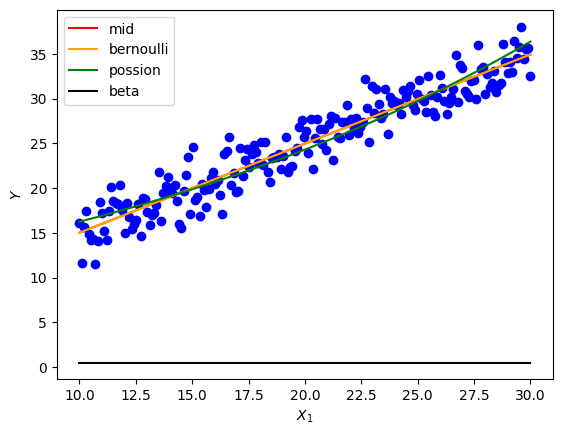

In [57]:
plt.scatter(x_train, y_train, c='blue')

plt.plot(x_new, y_pred_mid, c='red', label='mid')
plt.plot(x_new, y_pred_bernoulli, c='orange', label='bernoulli')
plt.plot(x_new, y_pred_possion, c='green', label='possion')
plt.plot(x_new, y_pred_beta, c='black', label='beta')

plt.legend()
plt.xlabel("$X_1$")
plt.ylabel("$Y$")
plt.show()